In [40]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

## Importing Data

In [41]:
# read data into memory
data_set = np.genfromtxt("hw04_data_set.csv", delimiter = ",",skip_header=1) # skip header

train_size = 150
test_size = 122
# get x and y values
x_train = data_set[:train_size,0]
x_test = data_set[train_size:,0]
y_train = data_set[:train_size,1].astype(int)
y_test = data_set[train_size:,1].astype(int)

# get number of classes and number of samples
K = np.max(y_train)
N = y_train.shape[0]

In [42]:
def rmse(methodName,p_hat,bin_width):
    rmse = 0
    if methodName=="Regressogram":
        for i in range(test_size):
            for b in range(len(right_borders)):
                if (left_borders[b] < x_test[i]) and (x_test[i] <= right_borders[b]):
                    rmse += (y_test[i] - p_hat[b])**2
        rmse = math.sqrt(rmse/test_size) 
    else: 
        for i in range(test_size):
            index=-1
            minVal=10000000
            for x in range(len(data_interval)):
                value=abs(x_test[i]-data_interval[x])
                if value<minVal:
                    minVal=value
                    index=x
            rmse += (y_test[i] - p_hat[index])**2
        rmse = math.sqrt(rmse/test_size)
        
    print(methodName,"=> RMSE is", rmse, "when h is", bin_width)

In [48]:
origin = 1.5
bin_width = 0.37
minimum_value = origin
maximum_value = 5.25 # from hw pdf 
data_interval = np.linspace(minimum_value, maximum_value, int((maximum_value-minimum_value)*100)+1)

### Regressogram

$\hat{g}(x) = \dfrac{\sum^N_{t=1}{b(x,x^t)r^t}}{\sum^N_{t=1}{b(x,x^t)}}$

$b(x,x^t) = 1$ if $x^t$ is the same bin with x \
$b(x,x^t) = 0$ otherwise

<ipython-input-44-9aa293742543>:9: RuntimeWarning: invalid value encountered in long_scalars
  p_hat = np.asarray([np.sum(((left_borders[i] < x_train) & (x_train <= right_borders[i])) * y_train)\


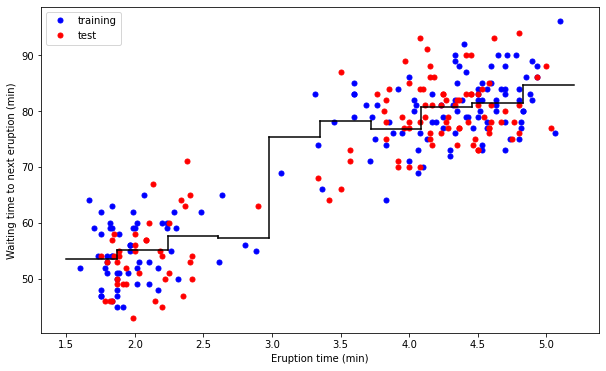

In [44]:
left_borders = np.arange(minimum_value, maximum_value, bin_width)
right_borders = np.arange(minimum_value + bin_width, maximum_value + bin_width, bin_width)

p_hat = np.asarray([np.sum(((left_borders[i] < x_train) & (x_train <= right_borders[i])) * y_train)\
/np.sum((left_borders[i] < x_train) & (x_train <= right_borders[i])) for i in range(len(left_borders))])

plt.figure(figsize = (10, 6))
plt.plot(x_train, y_train, "b.", markersize = 10, label = "training")
plt.plot(x_test, y_test, "r.", markersize = 10, label = "test")
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc = 'upper left')
for b in range(len(left_borders)):
    plt.plot([left_borders[b], right_borders[b]], [p_hat[b], p_hat[b]], "k-")
for b in range(len(left_borders) - 1):
    plt.plot([right_borders[b], right_borders[b]], [p_hat[b], p_hat[b + 1]], "k-")    
plt.show()

In [45]:
rmse("Regressogram",p_hat,bin_width)

Regressogram => RMSE is 5.962617204275407 when h is 0.37


### Running Mean Smoother

$\hat{g}(x) = \dfrac{\sum^N_{t=1}{w(\dfrac{x-x^t}{h})r^t}}{\sum^N_{t=1}{w(\dfrac{x-x^t}{h})}}$

$w(u) = 1$ if |u|<1/2 \
$w(u) = 0$ otherwise

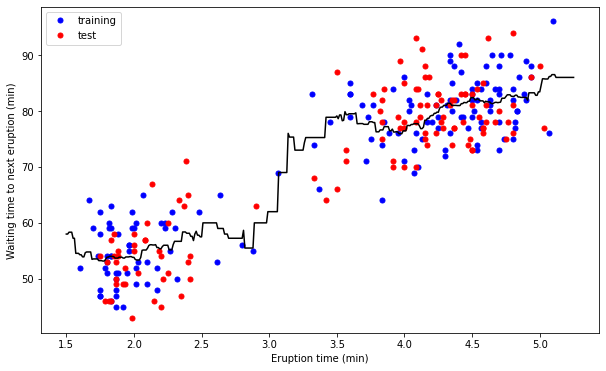

In [50]:
#p_hat=np.asarray([np.sum(((((x_train - x)/bin_width) <= 0.5) & (((x_train - x)/bin_width) >= -0.5))*y_train)/np.sum((((x_train - x)/bin_width) <= 0.5) & (((x_train - x)/bin_width) >= -0.5)) for x in data_interval])
p_hat=np.asarray([np.sum((np.abs((x_train - x)/bin_width) <= 0.5)*y_train)/
                  np.sum(np.abs((x_train - x)/bin_width) <= 0.5)for x in data_interval])


plt.figure(figsize = (10, 6))
plt.plot(x_train, y_train, "b.", markersize = 10, label = "training")
plt.plot(x_test, y_test, "r.", markersize = 10, label = "test")
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc = 'upper left')
plt.plot(data_interval, p_hat, "k-")
plt.show()

In [47]:
rmse("Running Mean Smoother",p_hat,bin_width)

Running Mean Smoother => RMSE is 6.0842227698408315 when h is 0.37


### Kernel Smoother

$\hat{g}(x) = \dfrac{\sum^N_{t=1}{K(\dfrac{x-x^t}{h})r^t}}{\sum^N_{t=1}{K(\dfrac{x-x^t}{h})}}$

$K(u)=K(\dfrac{x-x^t}{h})=\dfrac{1}{\sqrt{2\pi}}e^{[\dfrac{-u^2}{2}]}=\dfrac{1}{\sqrt{2\pi}}e^{[\dfrac{-(\dfrac{x-x_i}{h})^2}{2}]}$

In [34]:
def KernelFuncNumerator(x):
    return np.sum((1 / np.sqrt(2 * math.pi) * np.exp(-0.5 * (x - x_train)**2 / bin_width**2))*y_train)

In [35]:
def KernelFunc(x):
    return np.sum(1 / np.sqrt(2 * math.pi) * np.exp(-0.5 * (x - x_train)**2 / bin_width**2))

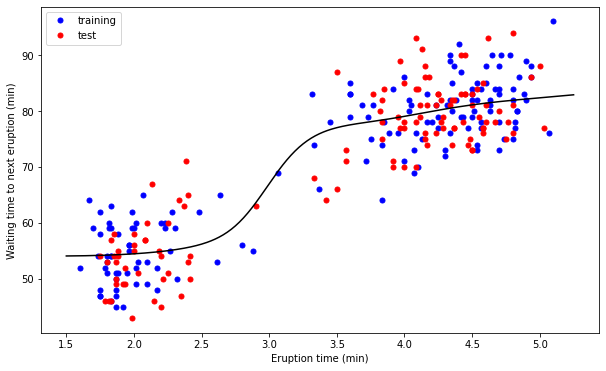

In [36]:
p_hat = np.asarray([KernelFuncNumerator(x)/KernelFunc(x) for x in data_interval])

plt.figure(figsize = (10, 6))
plt.plot(x_train, y_train, "b.", markersize = 10, label = "training")
plt.plot(x_test, y_test, "r.", markersize = 10, label = "test")
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(loc = 'upper left')
plt.plot(data_interval, p_hat, "k-")
plt.show()

In [37]:
rmse("Kernel Smoother",p_hat,bin_width)

Kernel Smoother => RMSE is 5.875422447171615 when h is 0.37
